In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
from melodic_contour import *
matplotlib.style.use('styles.mplstyle')

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import tslearn
from tslearn.metrics import cdist_dtw

from scipy.spatial import distance_matrix
from unidip.dip import diptst as diptest
import pickle

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## The principal components of contour space

In [2]:
def get_components(representation='centered', subset_size=1000, n_components=4):
    meta = pd.read_csv(f'../data/contours/contours-{subset_size}-metadata.csv', index_col=0)
    df = pd.read_csv(f'../data/contours/contours-{subset_size}-{representation}.csv', index_col=0)
    components = [[] for _ in range(n_components)]
    for dataset_id in meta.dataset_id.unique():
        c = df[meta['dataset_id'] == dataset_id].values
        pca = PCA(n_components=n_components)
        pca.fit(c)
        
        for i in range(n_components):
            comp = pca.components_[i, :]
            if len(components[i]) > 0:
                prev = components[i][-1]
                if np.linalg.norm(comp - prev) > np.linalg.norm(-1*comp - prev):
                    comp = -1 * comp
            components[i].append(comp)
        
    return np.array(components)

# get_components().shape

In [3]:
def get_components(representation='centered', subset_size=1000, n_components=3):
    meta = pd.read_csv(f'../data/contours/contours-{subset_size}-metadata.csv', index_col=0)
    df = pd.read_csv(f'../data/contours/contours-{subset_size}-{representation}.csv', index_col=0)
    components = [[] for _ in range(n_components)]
    explained_variance_ratios = []
    for dataset_id in meta.dataset_id.unique():
        c = df[meta['dataset_id'] == dataset_id].values
        pca = PCA(n_components=n_components, random_state=12345, svd_solver='full')
        pca.fit(c)
        
        for i in range(n_components):
            comp = pca.components_[i, :]
            if len(components[i]) > 0:
                prev = components[i][-1]
                if np.linalg.norm(comp - prev) > np.linalg.norm(-1*comp - prev):
                    comp = -1 * comp
            components[i].append(comp)
        explained_variance_ratios.append(pca.explained_variance_ratio_)
    return np.array(components), np.array(explained_variance_ratios)

# c, r = get_components()
# c.shape

In [4]:
def show_components(components, ratios=None):
    thin = dict(alpha=.3, lw=.5)
    thick = dict(lw=2)
    for i in range(len(components)):
        plt.plot(components[i].T, color=f'C{i}', **thin)
        plt.plot(components[i].mean(axis=0).T, color=f'C{i}', **thick)
    
    mean_ratios = ratios.mean(axis=0)
    plt.plot([0], [0], label=f'$C_1$ ({mean_ratios[0]:.0%})')
    plt.plot([0], [0], label=f'$C_2$ ({mean_ratios[1]:.0%})')
    plt.plot([0], [0], label=f'$C_3$ ({mean_ratios[2]:.0%})')

# show_components(*get_components('centered'))

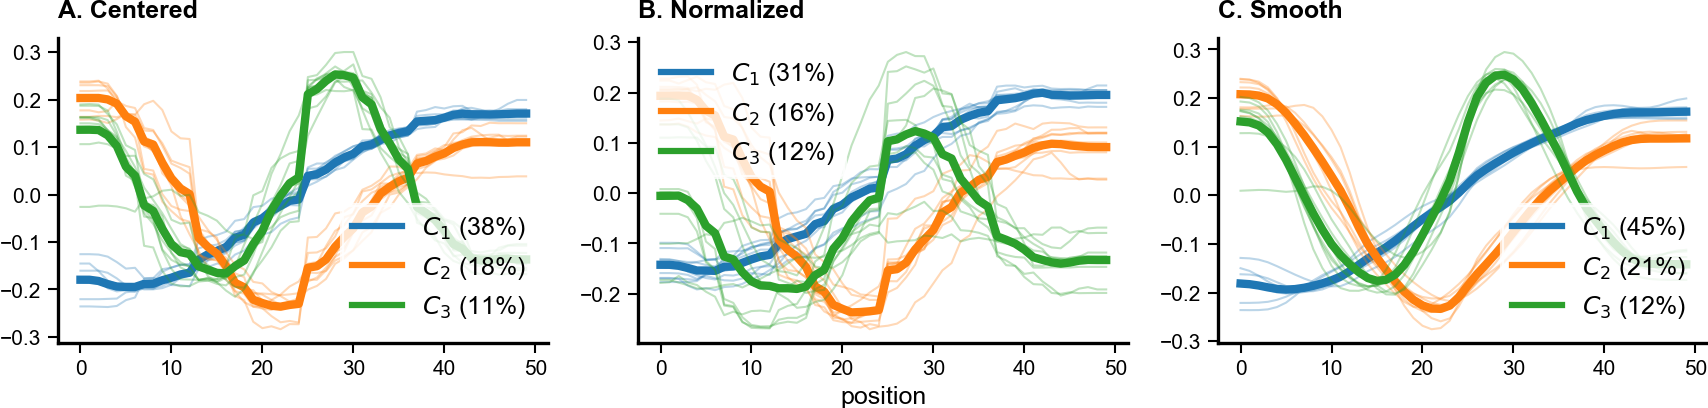

In [5]:
plt.figure(figsize=cm2inch(15, 4))

plt.subplot(131)
title('A. Centered')
components, ratios = get_components('centered')
mean_ratios = ratios.mean(axis=0)
show_components(*get_components('centered'))
# plt.plot([0], [0], 'k', lw=2, label='Avg.')
# plt.plot([0], [0], 'k', lw=.1, alpha=.5, label='1 dataset')
plt.legend()

plt.subplot(132)
title('B. Normalized')
show_components(*get_components('normalized'))
plt.xlabel('position')
plt.legend()

plt.subplot(133)
title('C. Smooth')
show_components(*get_components('smooth'))
plt.legend()

plt.tight_layout()
plt.savefig('../figures/fig-principal-components.pdf')

## Chebyshev

In [26]:
T0 = lambda x: np.ones(x.shape)
T1 = lambda x: x
T2 = lambda x:  2 * x**2 - 1 
T3 = lambda x:  4 * x**3 - 3 * x
T4 = lambda x:  8 * x**4 - 8 * x**2 + 1
T5 = lambda x: 16 * x**5 - 20 * x**3 + 5 * x

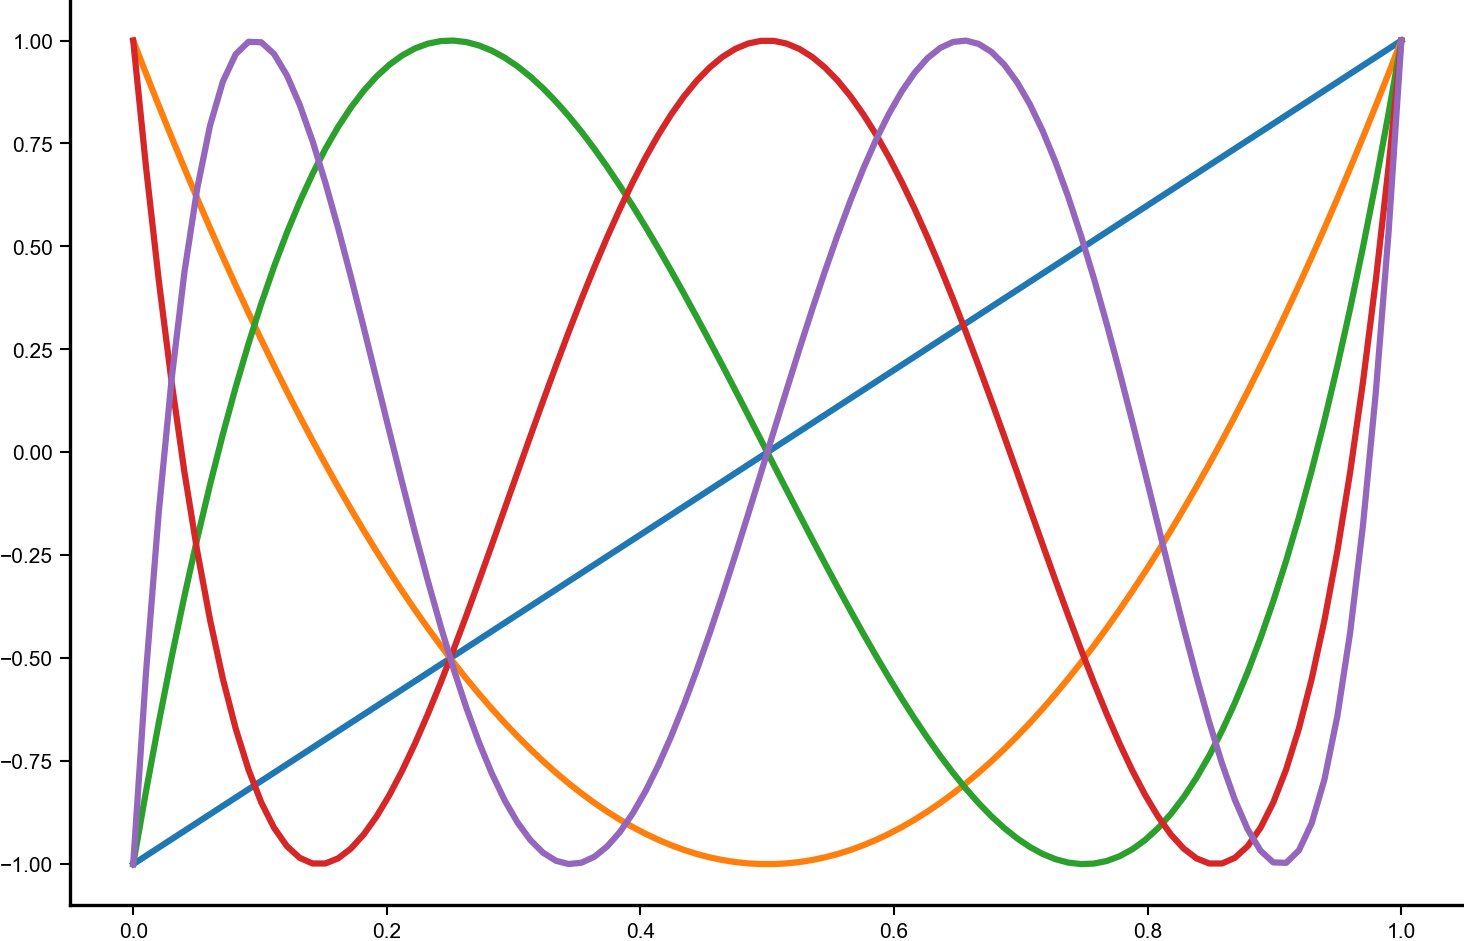

In [27]:
xs = np.linspace(0, 1, 100)
# plt.plot(xs, T0(2 * xs - 1))
plt.plot(xs, T1(2 * xs - 1))
plt.plot(xs, T2(2 * xs - 1))
plt.plot(xs, T3(2 * xs - 1))
plt.plot(xs, T4(2 * xs - 1))
plt.plot(xs, T5(2 * xs - 1))

## Intervalic representations

For intervalic representations the principal components are not so easy to interpret

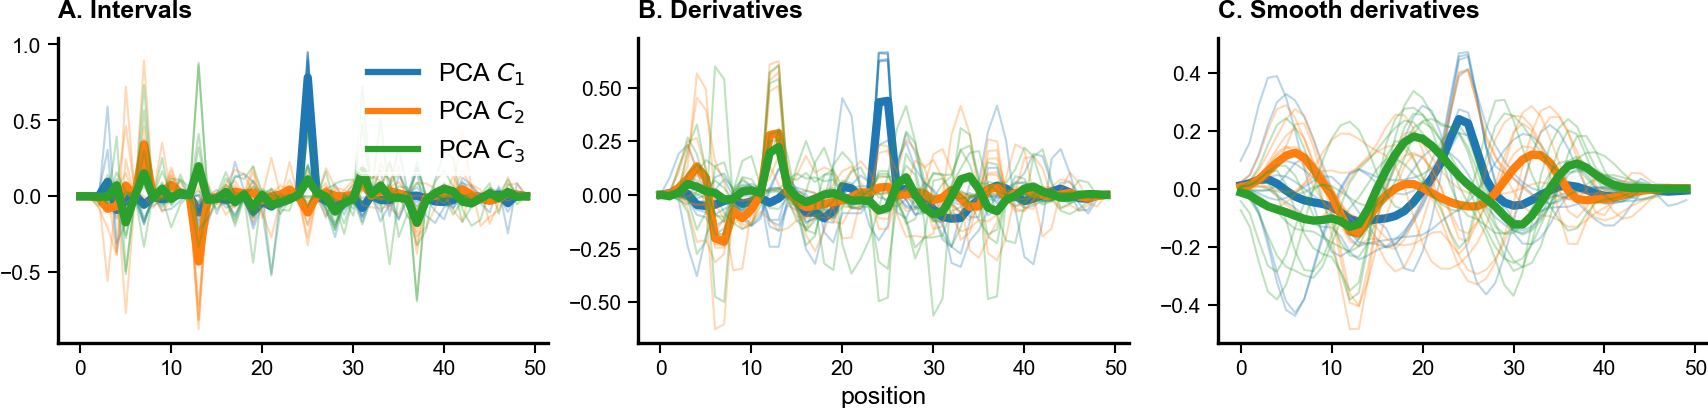

In [8]:
plt.figure(figsize=cm2inch(15, 4))

plt.subplot(131)
title('A. Intervals')
show_components(get_components('intervals'))
plt.plot([0], [0], label='PCA $C_1$')
plt.plot([0], [0], label='PCA $C_2$')
plt.plot([0], [0], label='PCA $C_3$')
# plt.plot([0], [0], 'k', lw=2, label='Avg.')
# plt.plot([0], [0], 'k', lw=.1, alpha=.5, label='1 dataset')
plt.legend()

plt.subplot(132)
title('B. Derivatives')
show_components(get_components('derivatives'))
plt.xlabel('position')

plt.subplot(133)
title('C. Smooth derivatives')
show_components(get_components('smooth_derivatives'))

plt.tight_layout()
plt.savefig('../figures/fig-principal-components-intervalic.pdf')

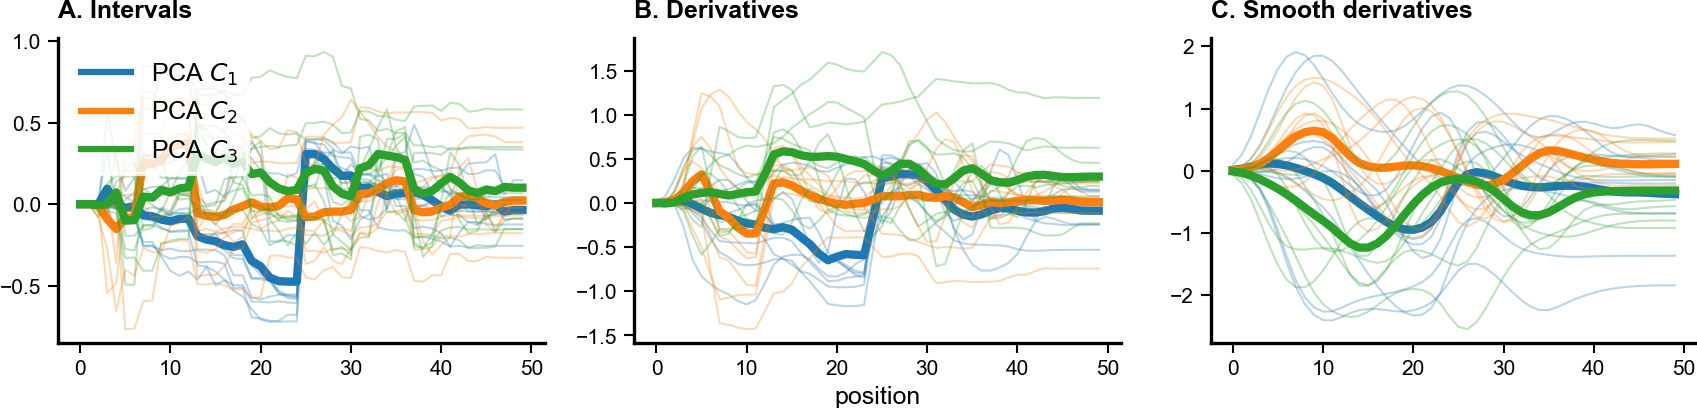

In [10]:
plt.figure(figsize=cm2inch(15, 4))

plt.subplot(131)
title('A. Intervals')
show_components(np.cumsum(get_components('intervals'), axis=2))
plt.plot([0], [0], label='PCA $C_1$')
plt.plot([0], [0], label='PCA $C_2$')
plt.plot([0], [0], label='PCA $C_3$')
# plt.plot([0], [0], 'k', lw=2, label='Avg.')
# plt.plot([0], [0], 'k', lw=.1, alpha=.5, label='1 dataset')
plt.legend()

plt.subplot(132)
title('B. Derivatives')
show_components(np.cumsum(get_components('derivatives'), axis=2))
plt.xlabel('position')

plt.subplot(133)
title('C. Smooth derivatives')
show_components(np.cumsum(get_components('smooth_derivatives'), axis=2))

plt.tight_layout()
plt.savefig('../figures/fig-principal-components-intervalic-cumsum.pdf')

## Scatter plots

In [66]:
subset_size = 1000
representation = 'smooth'
meta = pd.read_csv(f'../data/contours/contours-{subset_size}-metadata.csv', index_col=0)
df = pd.read_csv(f'../data/contours/contours-{subset_size}-{representation}.csv', index_col=0)
pca = PCA(n_components=2, random_state=12345, svd_solver='full')
pca.fit(df.values)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=12345,
    svd_solver='full', tol=0.0, whiten=False)

In [67]:
# Whats this?
# plt.imshow(pca.get_covariance())

In [49]:
# These parameters determine the PCA
pca2 = PCA(n_components=n_components, random_state=12345, svd_solver='full')
pca2.components_ = pca.components_
pca2.mean_ = pca.mean_

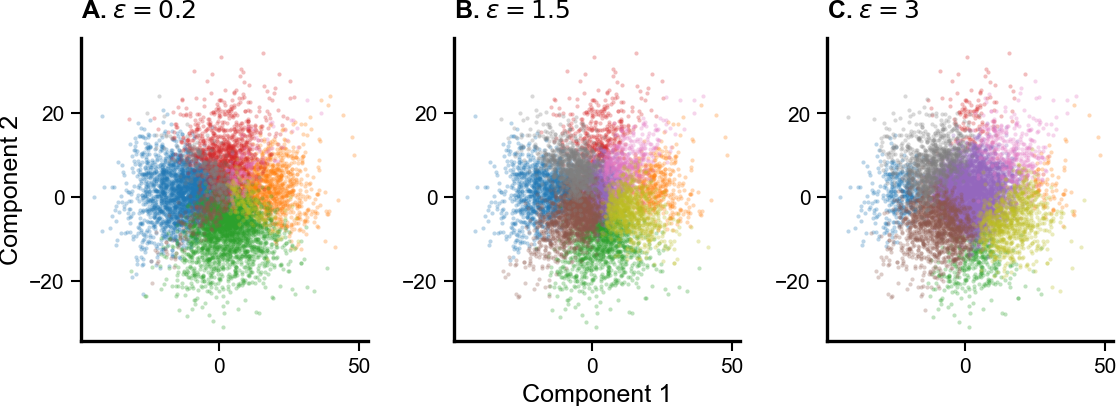

In [118]:
def show_huron_types(contours, pca, tolerance=0.2):
    T = HuronTypology(tolerance=tolerance)
    contour_types = [T.classify(Contour(c)) for c in contours]
    X = pca.transform(contours)

    for huron_type in T.types:
        matches = [t == huron_type for t in contour_types]
        x, y = X[matches].T
        plt.scatter(x, y, label=huron_type, s=1, alpha=.3, lw=0)

        
df = pd.read_csv(f'../data/contours/contours-1000-centered.csv', index_col=0)
 
plt.figure(figsize=cm2inch(10,4))
plt.subplot(131)
title('A. $\epsilon=0.2$')
show_huron_types(df.values, pca, tolerance=.2)
# plt.axis('off')
plt.ylabel('Component 2')

plt.subplot(132)
title('B. $\epsilon=1.5$')
show_huron_types(df.values, pca, tolerance=1.5)
# plt.axis('off')
plt.xlabel('Component 1')

plt.subplot(133)
title('C. $\epsilon=3$')
show_huron_types(df.values, pca, tolerance=3)
# plt.axis('off')
# plt.legend()

plt.tight_layout()
plt.savefig('../figures/pca-huron-types.pdf')

## Whatever

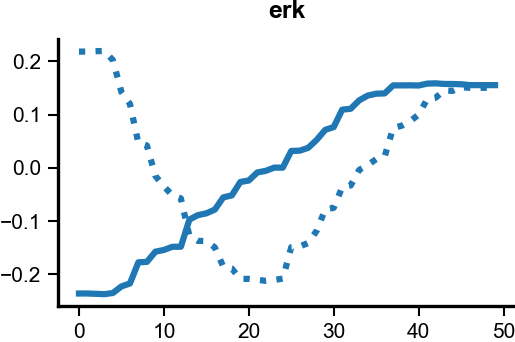

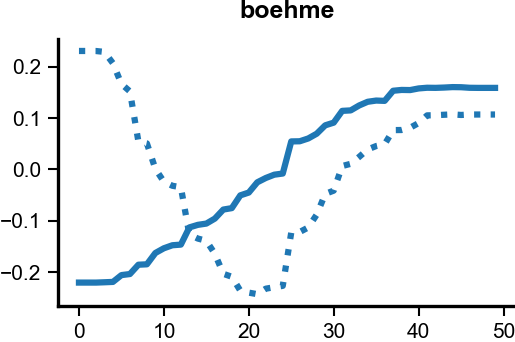

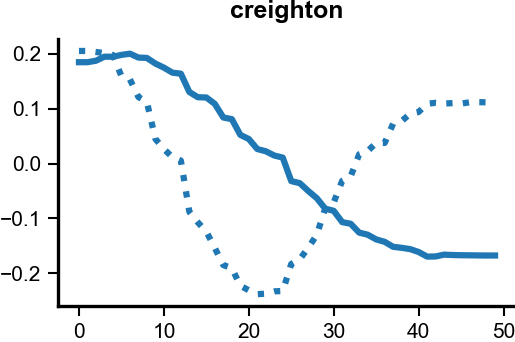

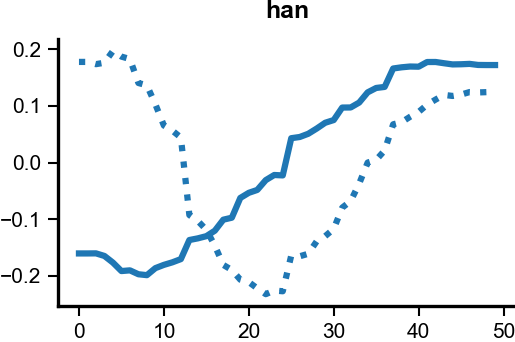

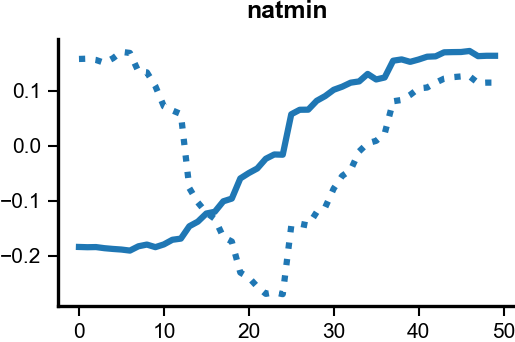

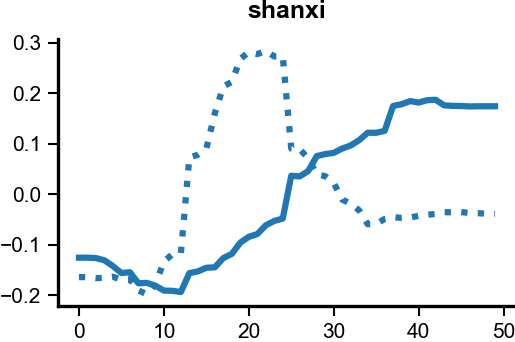

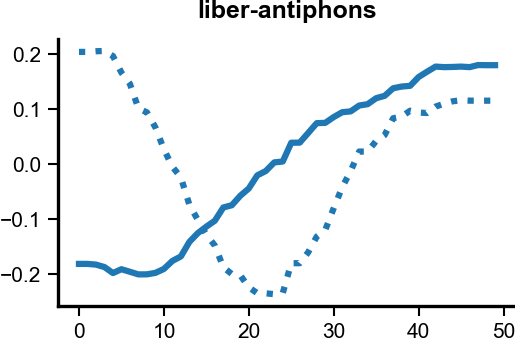

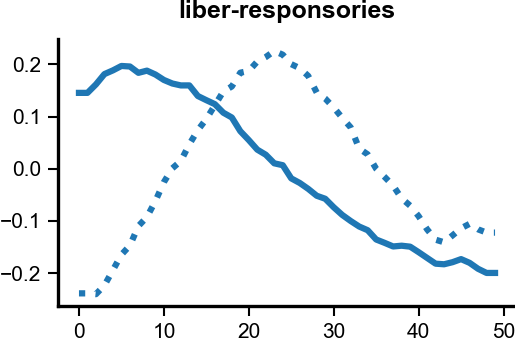

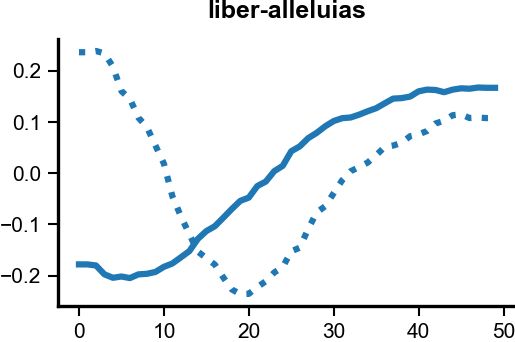

In [3]:
df = pd.read_csv(f'../data/contours/contours-1000-centered.csv', index_col=0)
for dataset_id in meta.dataset_id.unique():
    c = df[meta['dataset_id'] == dataset_id].values
    pca = PCA(n_components=2)
    pca.fit(c)
    plt.figure(figsize=cm2inch(5, 3))
    plt.title(dataset_id)
    l, = plt.plot(pca.components_[0, :]);
    plt.plot(pca.components_[1, :], color=l.get_color(), ls=':');

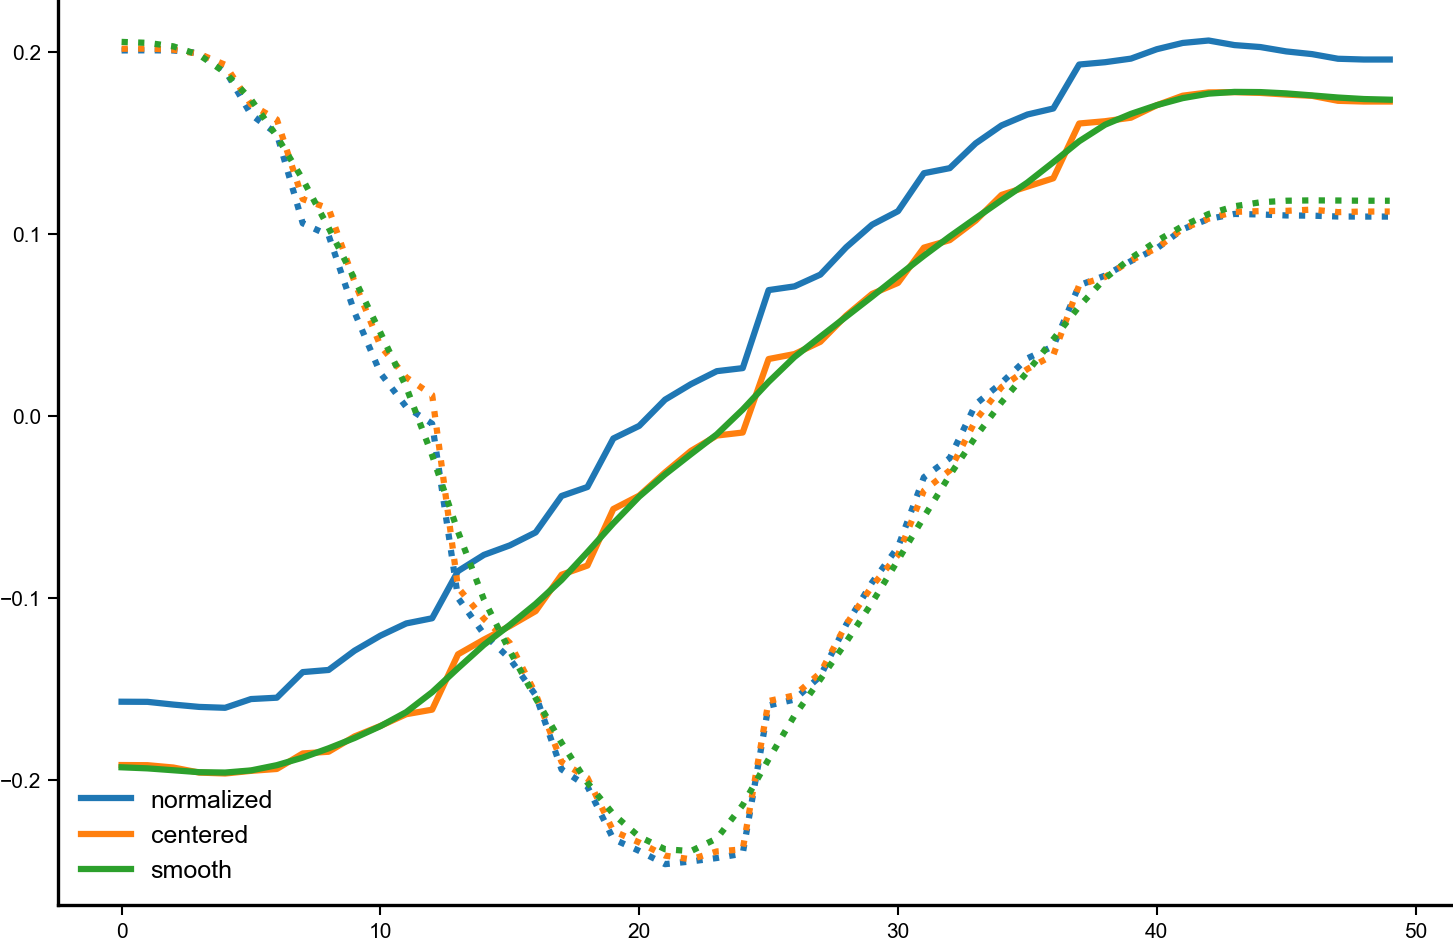

In [76]:
for r in ['normalized', 'centered', 'smooth']:
    df = pd.read_csv(f'../data/contours/contours-1000-{r}.csv', index_col=0)
    pca = PCA(n_components=4)
    pca.fit(df.values)
#     plt.subplot(221)
    l, = plt.plot(pca.components_[0, :], label=r);
#     plt.subplot(222)
    plt.plot(pca.components_[1, :], c=l.get_color(), ls=':');
#     plt.subplot(223)
#     plt.plot(pca.components_[2, :], c=l.get_color(), ls='--');
#     plt.subplot(224)
#     plt.plot(pca.components_[3, :], c=l.get_color(), ls='-.');
plt.legend()

In [77]:
X = np.loadtxt('../data/pca/pca-1000-smooth.txt.gz')

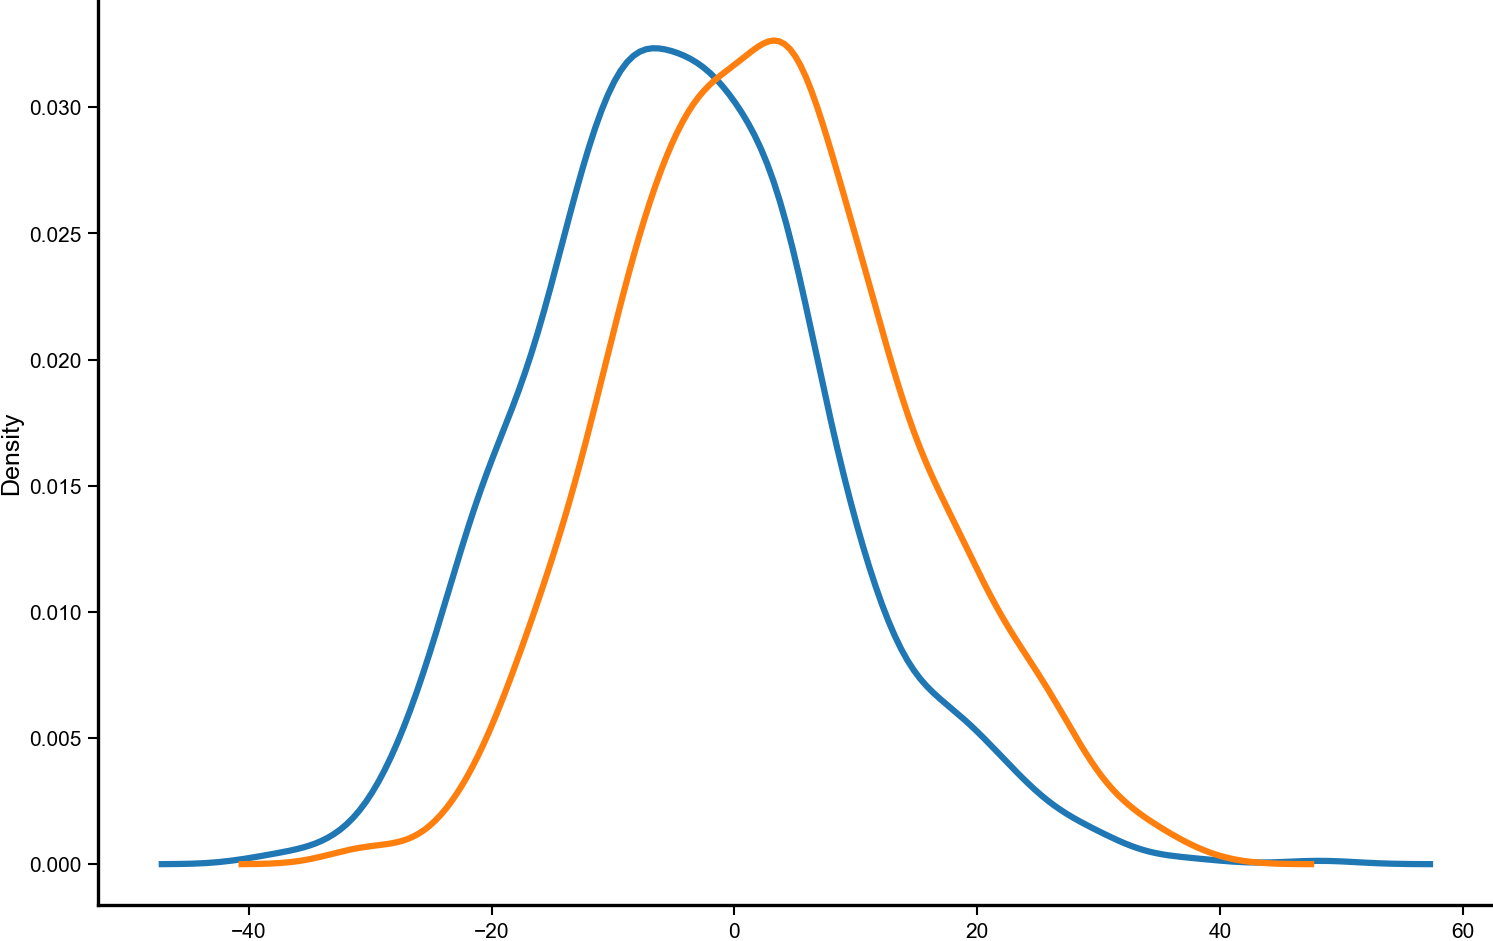

In [102]:
x, y = X[meta['dataset_id'] == 'han'].T
sns.kdeplot(x)
x, y = X[meta['dataset_id'] == 'erk'].T
sns.kdeplot(x)

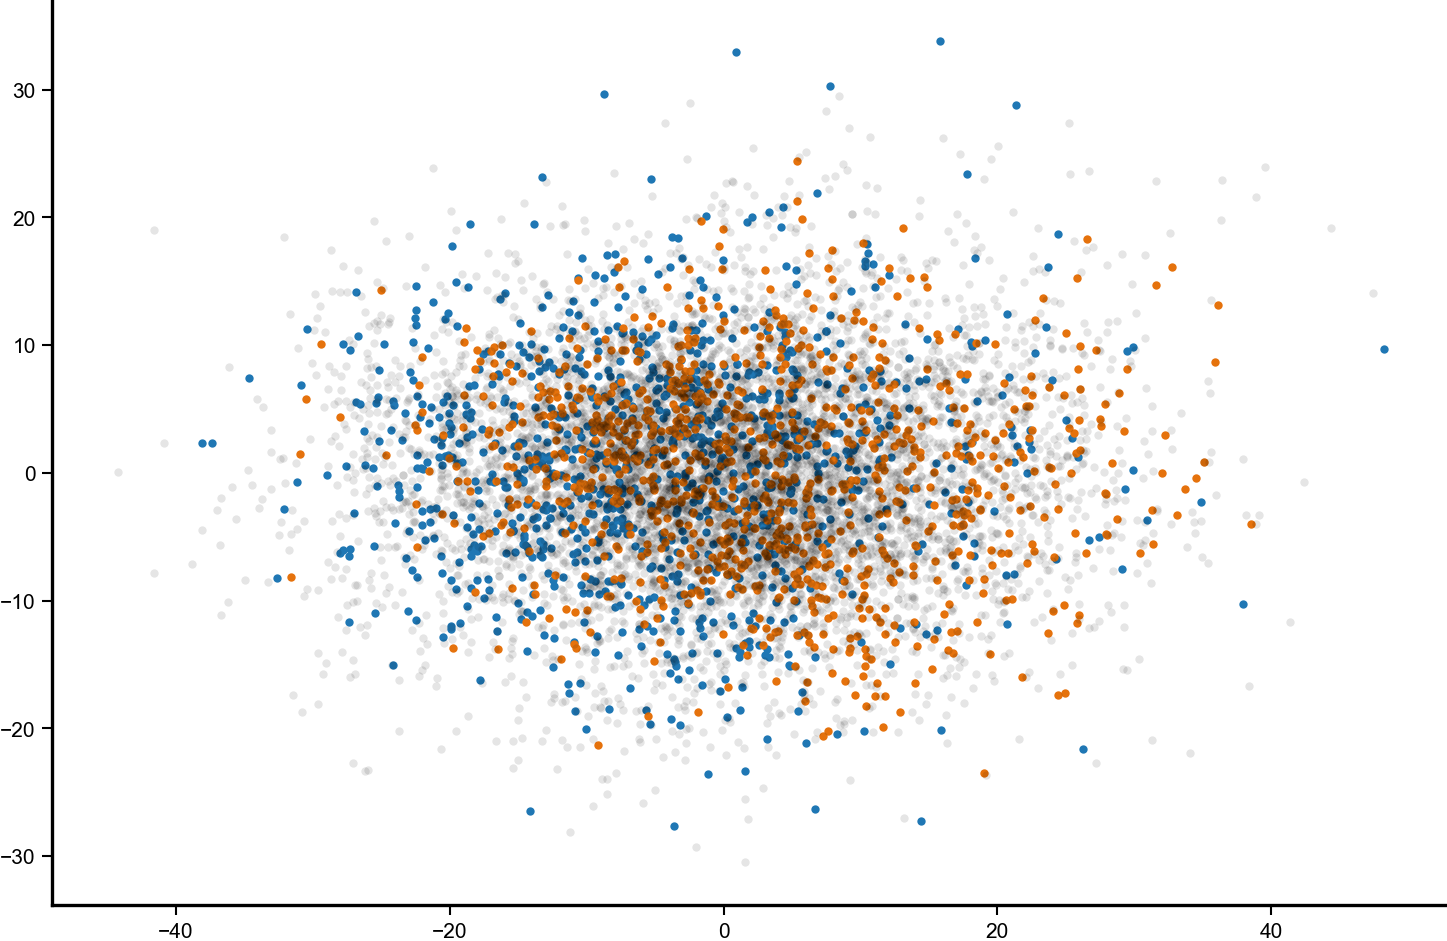

In [99]:

x, y = X[meta['dataset_id'] == 'han'].T
plt.scatter(x, y, s=4, lw=0)

x, y = X[meta['dataset_id'] == 'erk'].T
plt.scatter(x, y, s=4, lw=0)

x, y = X[match==False, :].T
plt.scatter(x, y, s=4, alpha=.1, lw=0, c='k')


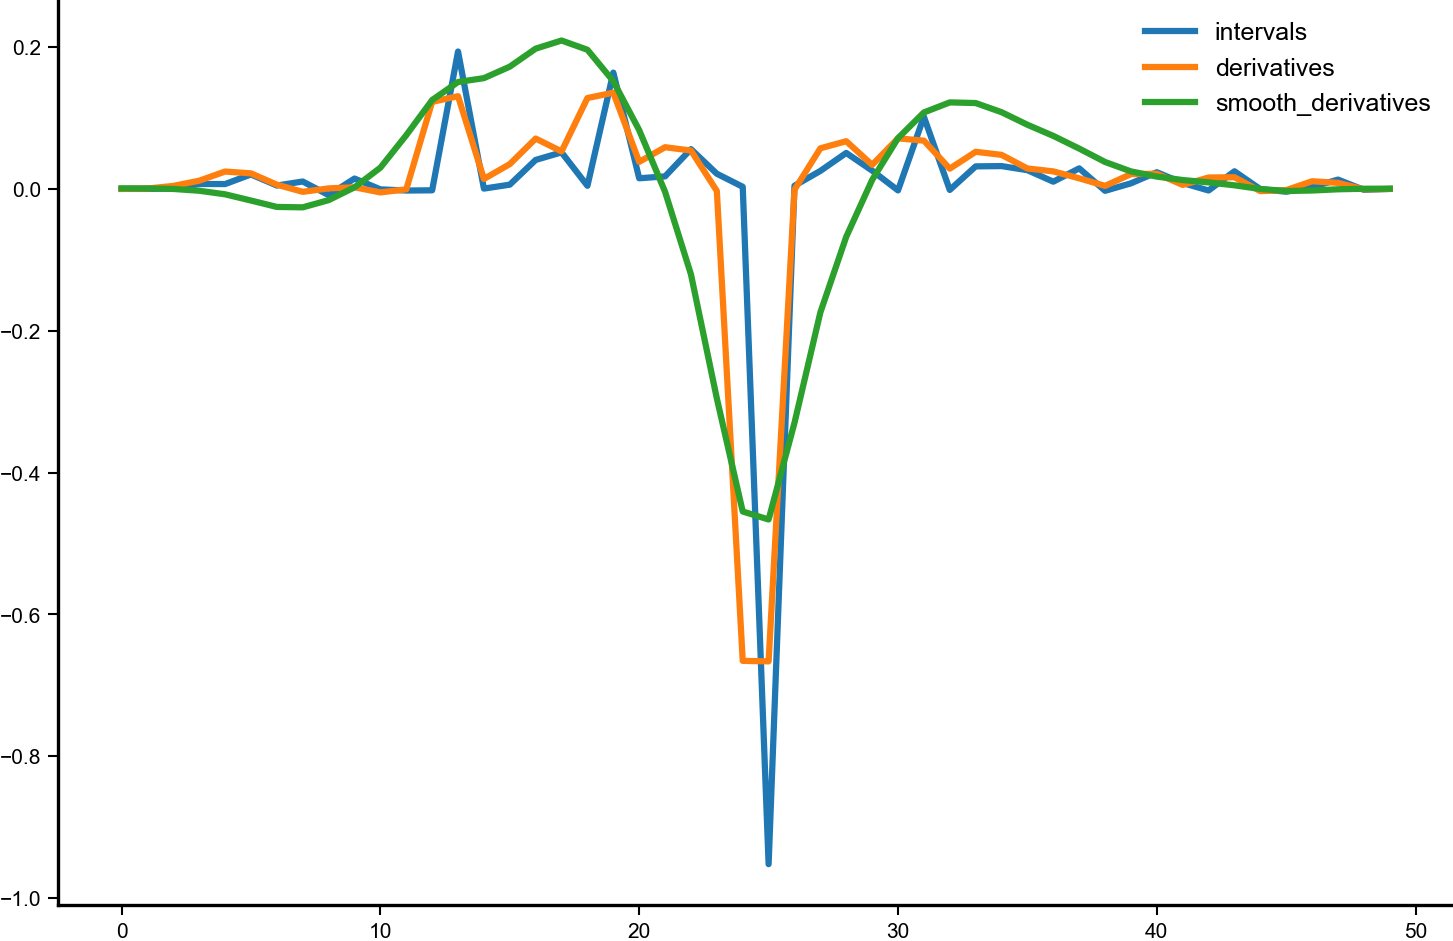

In [65]:
for r in ['intervals', 'derivatives', 'smooth_derivatives']:
    df = pd.read_csv(f'../data/contours/contours-1000-{r}.csv', index_col=0)
    pca = PCA(n_components=4)
    pca.fit(df.values)
    l, = plt.plot(pca.components_[0, :], label=r);
#     plt.plot(pca.components_[1, :], c=l.get_color(), ls=':');
#     plt.plot(pca.components_[2, :], c=l.get_color(), ls='--');
#     plt.plot(pca.components_[3, :], c=l.get_color(), ls='-.');
plt.legend()

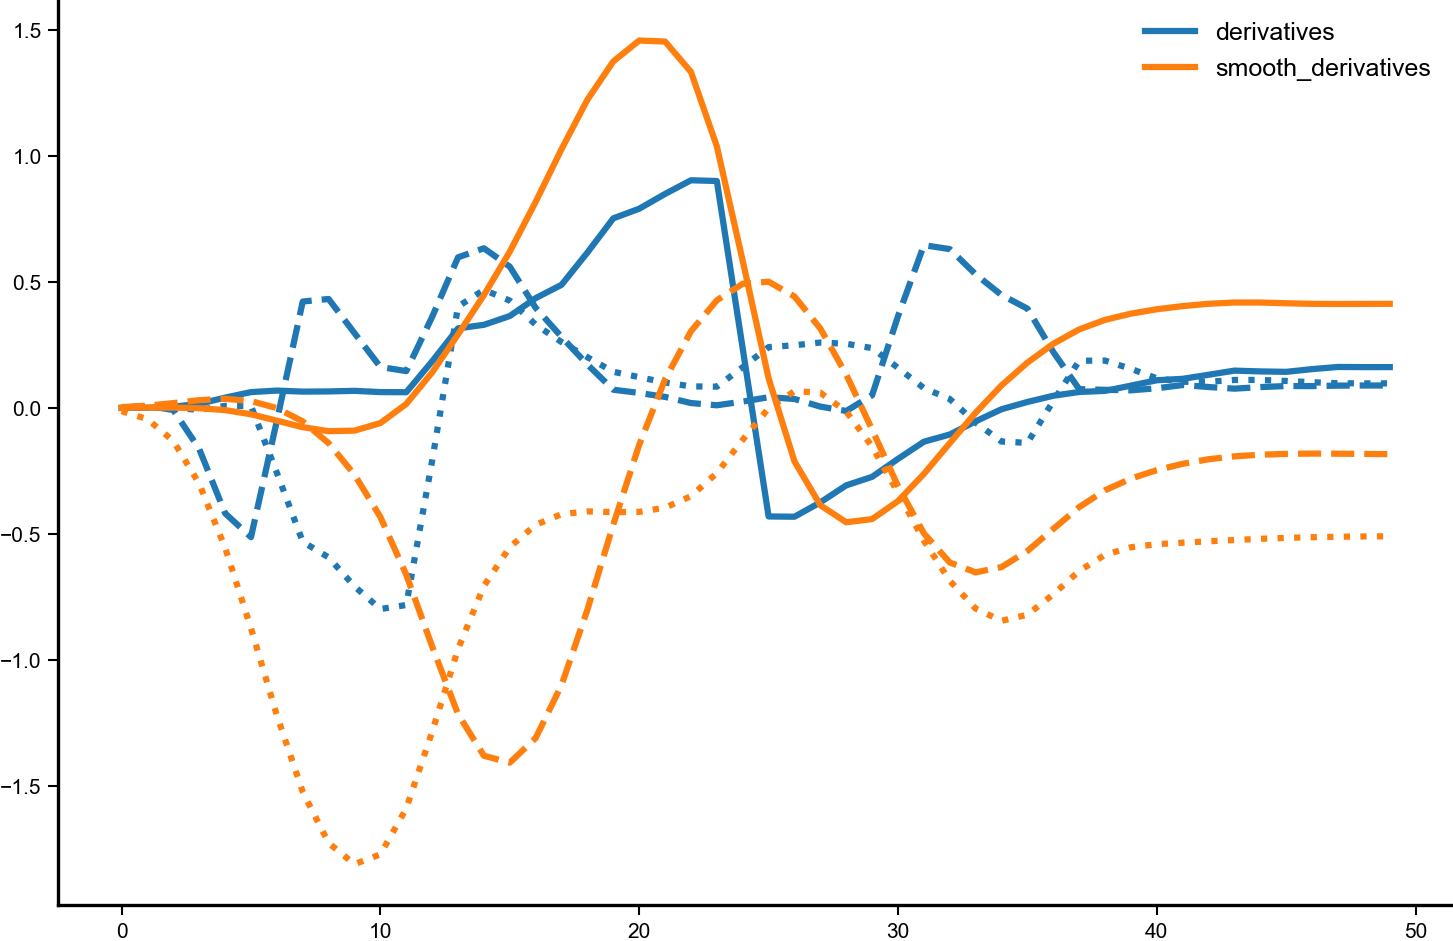

In [67]:
for r in ['derivatives', 'smooth_derivatives']:
    df = pd.read_csv(f'../data/contours/contours-1000-{r}.csv', index_col=0)
    pca = PCA(n_components=4)
    pca.fit(df.values)
    l, = plt.plot(np.cumsum(pca.components_[0, :]), label=r);
    plt.plot(np.cumsum(pca.components_[1, :]), c=l.get_color(), ls=':');
    plt.plot(np.cumsum(pca.components_[2, :]), c=l.get_color(), ls='--');
#     plt.plot(np.cumsum(pca.components_[3, :]), c=l.get_color(), ls='-.');
plt.legend()

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

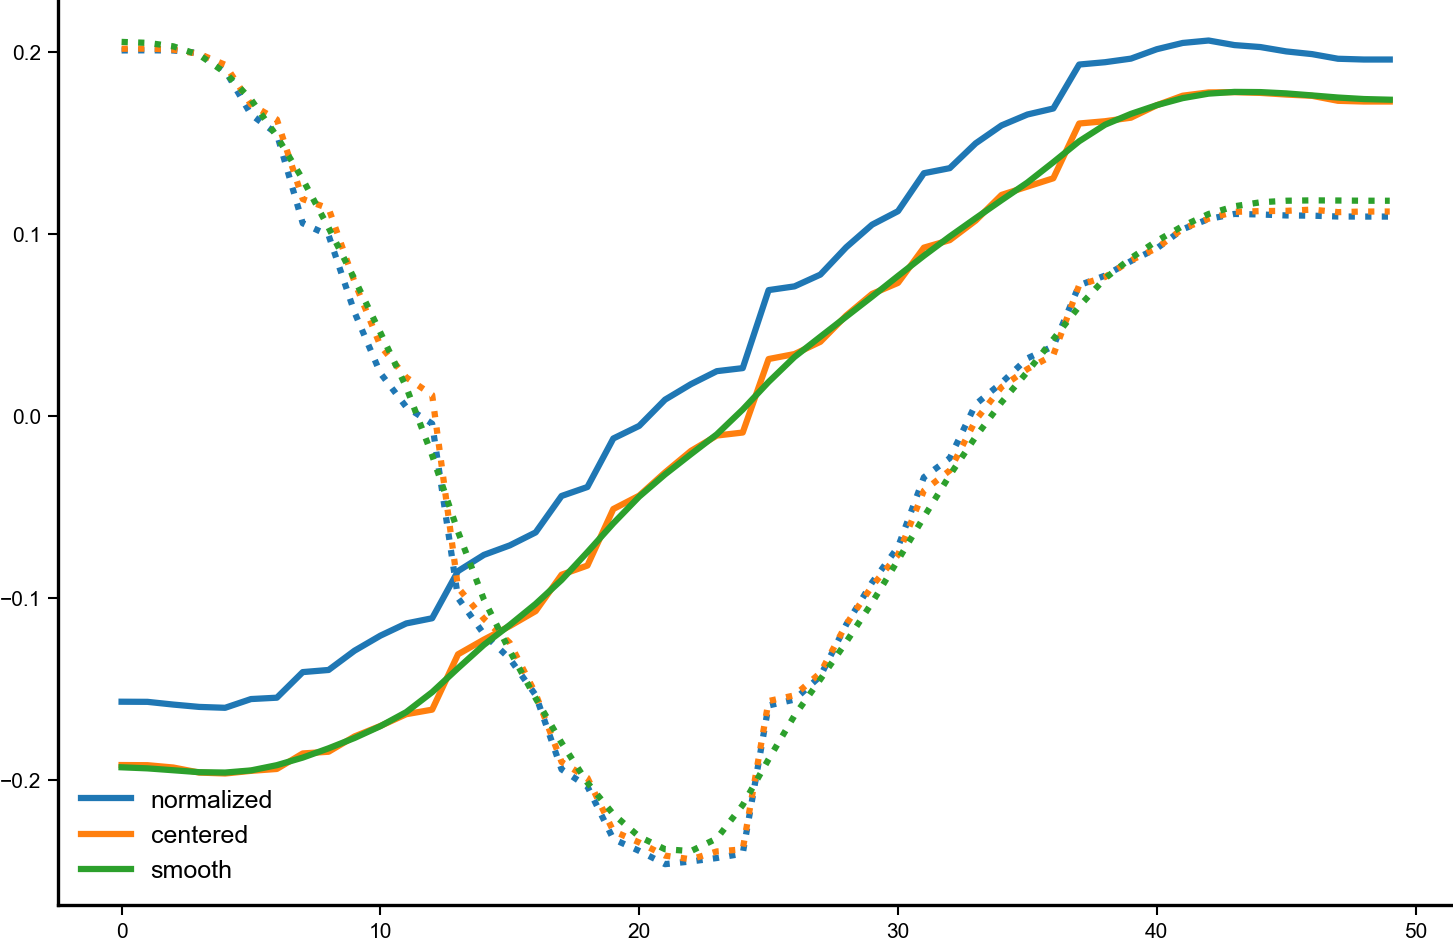

In [17]:
for r in ['normalized', 'centered', 'smooth']:
    with open(f'../data/pca/pca-1000-{r}.model.pickle', 'br') as h:
        pca = pickle.load(h)
        l, = plt.plot(pca.components_[0, :], label=r);
        plt.plot(pca.components_[1, :], c=l.get_color(), ls=':');
    plt.legend()

In [18]:
X = np.loadtxt('../data/pca/pca-1000-normalized.txt.gz')

In [19]:
X

array([[ 2.4559187 ,  0.00384378],
       [-1.89178149,  0.42901576],
       [ 0.55751563, -1.24347976],
       ...,
       [-0.92410782,  1.11126612],
       [ 1.02234909, -0.65843285],
       [-0.59318092, -0.58464744]])